In [708]:
#1) Regroup labels?
#2) Lav rigtig model. Hvad indebærer det? parameter, preprocessing, model?
#3) Evaluation and Conclusion
#4) Kør på liar, why is liar train, val, test? HVordan og hvorledes med Liar?
#5) More of the dataset?
#6) fake vs reliable histogram
#7) mest brugte ord inden og efter clean, osv
#8) nan values

In [709]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from cleantext import clean
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from collections import Counter
import subprocess
import zipfile
import io
import csv
import zipfile38 as zipfile
from dask import dataframe as dd
from sklearn.model_selection import train_test_split
import h5py
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.pyplot import bar
from matplotlib.pyplot import xticks
from matplotlib.pyplot import show
import itertools, sys
from collections import Counter


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Baxe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [710]:
# Define settings for cleaning
def clean_text(text):
    """Calls the clean function from cleantext clean on a string"""
    t = clean(text,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,         # fully strip line breaks as opposed to only normalizing them NOT WORKING?
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="URL",
    replace_with_email="EMAIL",
    replace_with_phone_number="PHONE",
    replace_with_number="NUM",
    replace_with_digit="0",
    replace_with_currency_symbol="CUR",
    lang="en",                       # set to 'de' for German special handling
    )
    return t


pd.set_option("display.max_colwidth", 10000000)    
print("Done")    
    


Done


In [711]:
""" #Small df
print("Getting csv...")
df = pd.read_csv('https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv')
print(type(df)) """

' #Small df\nprint("Getting csv...")\ndf = pd.read_csv(\'https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv\')\nprint(type(df)) '

In [712]:
csv_textfilereader = pd.read_csv(r'C:\Users\Baxe\Documents\Uni\DataScience\Aflevering3\git\news_cleaned_2018_02_13.csv', chunksize=1000000, iterator=True)
first_chunk = csv_textfilereader.get_chunk(10000)
first_article = first_chunk.iloc[0]
print(first_article)

Unnamed: 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0
id                                                                                                                                                                                                                             

In [713]:
#Small df
print("Getting csv...")
LiarVal = pd.read_csv(r'C:\Users\Baxe\Documents\Uni\DataScience\Aflevering3\git\valid.tsv', sep='\t')
#save the third column as a list
LiarValArticles = LiarVal.iloc[:, 2].values.tolist()
LiarValLables = LiarVal.iloc[:, 1].values.tolist()
print(LiarValArticles[0])
print(LiarValLables[0])


Getting csv...
When Obama was sworn into office, he DID NOT use the Holy Bible, but instead the Kuran (Their equivalency to our Bible, but very different beliefs).
pants-fire


In [714]:
article_texts = df['content'].tolist()

In [715]:


def clean_article_texts(article_texts):
    # Download stopwords and initialize stemmer
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    snowball = SnowballStemmer(language='english')

    cleaned_texts = []
    for article in article_texts:
        # Clean the text
        cleaned = clean_text(article)

        # Tokenize the text
        words = nltk.word_tokenize(cleaned)

        # Remove stopwords and stem the words
        filtered_words = [snowball.stem(word.lower()) for word in words if word.lower() not in stop_words]

        # Concatenate the filtered words into a single string
        cleaned_text = ' '.join(filtered_words)
        cleaned_texts.append(cleaned_text)

    return cleaned_texts



In [716]:
"""     # Clean dataframe function
def clean_df(df):
        print("Getting num words...")
        words = df['content'].str.split()
        print(words)
        unique_words_before = set(word for word_list in words for word in word_list)

        num_unique_words_before = len(unique_words_before)
        print("Number unique words before cleaning: ", num_unique_words_before)

        print("Cleaning...")
        for index, row in df.iterrows():
            cleaned = clean_text(df.at[index,'content'])
            df.at[index,'content'] = cleaned
            
        words_clean = df['content'].str.split()
        unique_words_clean = set(word for word_list in words_clean for word in word_list)

        num_unique_words_clean = len(unique_words_clean)
        print("Number of unique words after cleaning", num_unique_words_clean) 
        print("How many percent unique words were removed ", 1-num_unique_words_clean/num_unique_words_before) 


        print("Tokenizing and removing stopwords...")
        stop_words = set(stopwords.words('english'))
        for index, row in df.iterrows():    
            df.at[index,'content'] = nltk.word_tokenize(row['content'])
            
            filtered_sentence = []
            for w in df.at[index,'content']:
                if w not in stop_words:
                    filtered_sentence.append(w)
            
            df.at[index,'content'] = filtered_sentence
            
        # Unique words and num after stop
        words = set(word for content in df['content'] for word in content)

        # get the set of unique words
        unique_words_stop = set(words)

        num_unique_words_stop = len(unique_words_stop)
        print("Number of unique words after removing stopwords: ", num_unique_words_stop)
        print("How many percent were removed: ", 1-num_unique_words_stop/num_unique_words_clean)

        print("Stemming")
        snowball = SnowballStemmer(language='english')
        for index, row in df.iterrows():   
            stemmed = []
            for word in df.at[index,'content']:
                stemmed.append(snowball.stem(word))
            df.at[index,'content'] = stemmed

        # concatenate all the lists into a single list of words
        words = [word for content in df['content'] for word in content]
        # get the set of unique words
        unique_words_stem = set(words)
        # get the number of unique words

        num_unique_words_stem = len(unique_words_stem)
        print("Number of unique words after stemming: ", num_unique_words_stem)
        print("How many percent were removed: ", 1-num_unique_words_stem/num_unique_words_stop)


        print("Done...")
        return df, unique_words_before, unique_words_clean, unique_words_stop, unique_words_stem 
        
 """

'     # Clean dataframe function\ndef clean_df(df):\n        print("Getting num words...")\n        words = df[\'content\'].str.split()\n        print(words)\n        unique_words_before = set(word for word_list in words for word in word_list)\n\n        num_unique_words_before = len(unique_words_before)\n        print("Number unique words before cleaning: ", num_unique_words_before)\n\n        print("Cleaning...")\n        for index, row in df.iterrows():\n            cleaned = clean_text(df.at[index,\'content\'])\n            df.at[index,\'content\'] = cleaned\n            \n        words_clean = df[\'content\'].str.split()\n        unique_words_clean = set(word for word_list in words_clean for word in word_list)\n\n        num_unique_words_clean = len(unique_words_clean)\n        print("Number of unique words after cleaning", num_unique_words_clean) \n        print("How many percent unique words were removed ", 1-num_unique_words_clean/num_unique_words_before) \n\n\n        print("T

### 

In [717]:
""" # Save original data to CSV
first_chunk.to_csv('original_data.csv', index=False)

# Clean the data
cleaned_df = clean_df(first_chunk)

# Save cleaned data to CSV
cleaned_df.to_csv('cleaned_data.csv', index=False) """

" # Save original data to CSV\nfirst_chunk.to_csv('original_data.csv', index=False)\n\n# Clean the data\ncleaned_df = clean_df(first_chunk)\n\n# Save cleaned data to CSV\ncleaned_df.to_csv('cleaned_data.csv', index=False) "

In [718]:
df, unique_words_before, unique_words_stem = clean_article_texts(article_texts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Baxe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ValueError: too many values to unpack (expected 3)

In [ ]:
""" df, unique_words_before, unique_words_clean, unique_words_stop, unique_words_stem = clean_df(first_chunk)
unique_words = unique_words_stem """


Getting num words...
0                                                                          [Life, is, an, illusion,, at, least, on, a, quantum, level,, in, a, theory, which, has, recently, been, confirmed, by, a, set, of, researchers., They, finally, have, the, means, to, test, John, Wheeler’s, delayed-choice, theory, and, concluded, that, the, physicist, was, right., In, 1978,, Mr, Wheeler’s, proposed, experiment, involved, a, moving, object, that, was, given, the, choice, to, act, like, a, wave, or, a, particle, –, the, former, acting, as, a, vibration, with, a, frequency, that, can, distinguish, it, from, other, waves, and, the, latter, having, no, frequency, that, you, can, determine, its, position, in, space,, unlike, a, wave, –, and, ...]
1                                                                                                                                                                                                                                               

In [ ]:
#Part 1 - Task 2
print("Counting number of urls, dates and num, and fake news and trump")
url = 0
num = 0
trump=0
fakenews = 0
notfake = 0

for index, row in df.iterrows():
    for word in df.at[index,'content']:
        #print(word)
        if word == 'url':
            url = url+1
        if word == 'num':
            num = num+1
        if word == 'trump':
            trump = trump+1
    if df.at[index,'type'] == 'fake':
        fakenews = fakenews+1
    else:
        notfake = notfake+1
print("Num urls: ", url)
print("Num num: ", num)
print("Num trump: ", trump)
print("Num fake: ", fakenews)
print("Num notfake: ", notfake)

Counting number of urls, dates and num, and fake news and trump
Num urls:  6148
Num num:  96823
Num trump:  15289
Num fake:  3663
Num notfake:  6337


Visualization of the key properties of the dataset

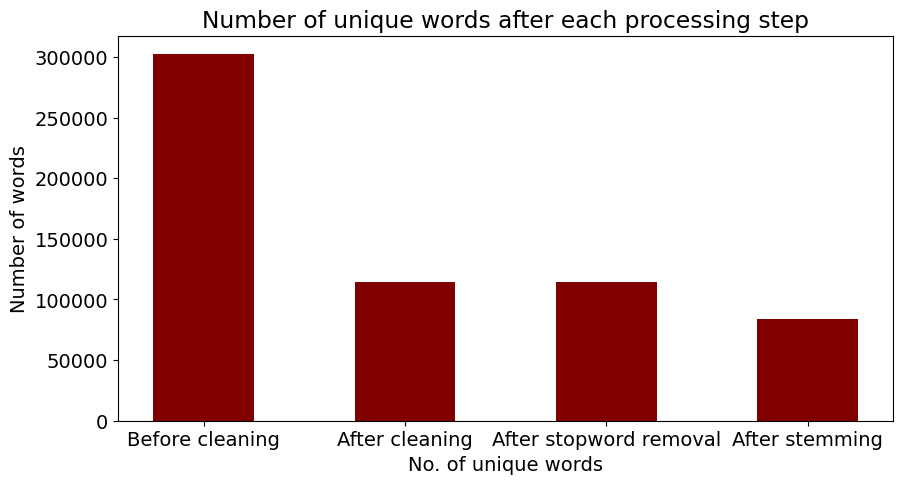

In [ ]:
# Plotting the bar chart 
data = {'Before cleaning': len(unique_words_before), 'After cleaning': len(unique_words_clean), 'After stopword removal': len(unique_words_stop), 'After stemming': len(unique_words_stem)}
dataset = list(data.keys())
values = list(data.values())
bar(dataset, values, color = 'maroon', width = 0.5)
plt.xlabel('No. of unique words')
plt.ylabel('Number of words')
plt.title('Number of unique words after each processing step')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

##### This code splits a DataFrame df into training, validation, and testing sets, with a 80:10:10 ratio. The X variable contains the content of the articles, while the y variable contains the type of the articles (reliable/fake).

In [ ]:
X, y = df.content, df['type']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)


#### make_bin function to convert categorical data into binary labels
##### make_bin is a function that takes in a list of categorical data and converts it into a list of binary labels. The function iterates through the input list and assigns a binary label of 0 to each non-'fake' element and a label of 1 to each 'fake' element. The resulting binary labels are returned as a list, which can be used as target values for machine learning algorithms.

In [ ]:
def make_bin(to_bin):
    to_bin = np.asarray(to_bin)
    reliable = 0
    fake = 0
    bin_list = []
    for i in range(len(to_bin)):
        if to_bin[i] == "nan":
            print("nan")
        if to_bin[i] == "Na":
            print("Na")
        if to_bin[i] != 'fake' and to_bin[i] != 'satire' and to_bin[i] != 'conspiracy' and to_bin[i] != 'junksci' and to_bin[i] != 'hate' and to_bin[i] != 'clickbait' and to_bin[i] != 'unreliable' and to_bin[i] != 'rumor':
            bin_list.append(0)
            reliable = reliable +1
        else:
            bin_list.append(1)
            fake = fake+1
        #print(to_bin[i])
    return bin_list, fake, reliable

In [ ]:
y_train_bin, LabelFa, LabelRe  = make_bin(y_train)
y_val_bin, no1, no2 = make_bin(y_val)
y_test_bin, no3, no4 = make_bin(y_test)



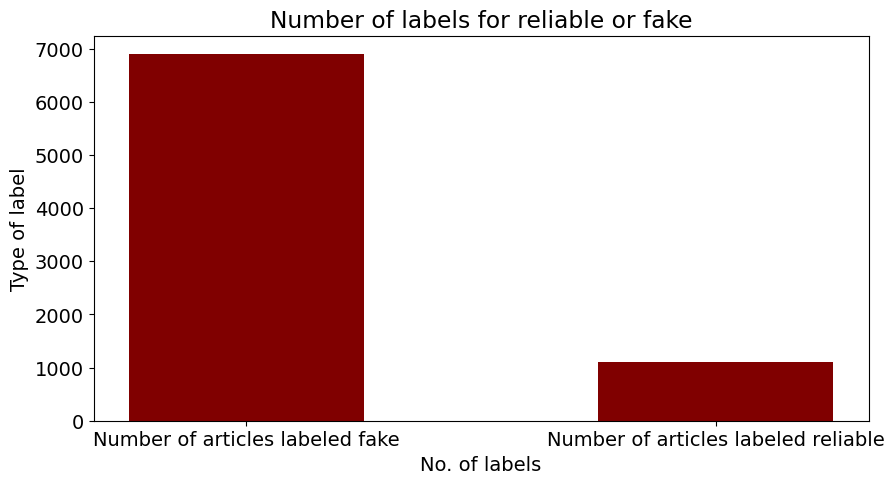

In [ ]:
# Bar chart showing number of fake labels and number of reliable
data = {'Number of articles labeled fake': LabelFa, 'Number of articles labeled reliable': LabelRe }
labels = list(data.keys())
values = list(data.values())
bar(labels, values, color = 'maroon', width= 0.5)
plt.xlabel('No. of labels')
plt.ylabel('Type of label')
plt.title('Number of labels for reliable or fake')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

#### Liar dataset

In [ ]:
y_val_liar, no5, no6 = make_bin(LiarValLables)

#### X_vectoriser function to transform text data into a sparse matrix representation
##### X_vectoriser is a function that takes in a list of text data as input, concatenates the words in each string, and transforms the resulting text data into a sparse matrix representation using the CountVectorizer from scikit-learn. The resulting matrix can be used as input to machine learning algorithms.

In [ ]:
def X_vectoriser(vectee):
    vectee = [' '.join(words) for words in vectee]
    vectorizer = CountVectorizer(vocabulary=unique_words)
    vectee = vectorizer.fit_transform(vectee)
    return vectee

In [ ]:
X_train_vec = X_vectoriser(X_train)
X_val_vec = X_vectoriser(X_val)
X_test_vec = X_vectoriser(X_test)

c:\Users\Baxe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


#### liar dataset

In [ ]:
X_val_liar, k1, k2,k3, UWC = clean_df(LiarValArticles)
unique_words_liar = UWC

Getting num words...


TypeError: list indices must be integers or slices, not str

In [ ]:
X_val_liar_Clean = X_vectoriser(X_val_liar)

### A simple logistic model:

#### Predicting on the FakeNewsCorpus dataset

In [ ]:
simple_log_model = LogisticRegression(max_iter=100000)
simple_log_model.fit(X_train_vec, y_train_bin)
y_pred = simple_log_model.predict(X_val_vec)

acc_simple_log = accuracy_score(y_val_bin, y_pred)
print("Accuracy of simple logistic regression: ", acc_simple_log)


Accuracy of simple logistic regression:  0.915


#### Predicting on the liar validation set: 

In [ ]:
simple_log_model_liar = LogisticRegression(max_iter=100000)
simple_log_model_liar.fit(X_train_vec, y_train_bin)
y_pred = simple_log_model_liar.predict(X_val_liar_Clean)

acc_simple_log = accuracy_score(y_val_liar, y_pred)
print(accuracy_score(y_val_liar, y_pred))

0.0


### Alt nedenfor er rettet mod den komplicerede model

#### Gaussion model: (kan ikke køre med lige så meget data som den logistiske)


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# create a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_vec.toarray(), y_train_bin)

# train the model on the resampled data
simple_nb_model = GaussianNB()
simple_nb_model.fit(X_train_resampled, y_train_resampled)

# make predictions on the validation data
y_pred2 = simple_nb_model.predict(X_val_vec.toarray())

# evaluate the accuracy of the model's predictions
acc_gaus = accuracy_score(y_val_bin, y_pred2)
print(accuracy_score(y_val_bin, y_pred2))


0.707


#### Logistisk model with confusion matrix and classification report:

Accuracy for C=0.1: 0.907
Best C: 0.1
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       156
           1       0.95      0.94      0.94       844

    accuracy                           0.91      1000
   macro avg       0.82      0.84      0.83      1000
weighted avg       0.91      0.91      0.91      1000



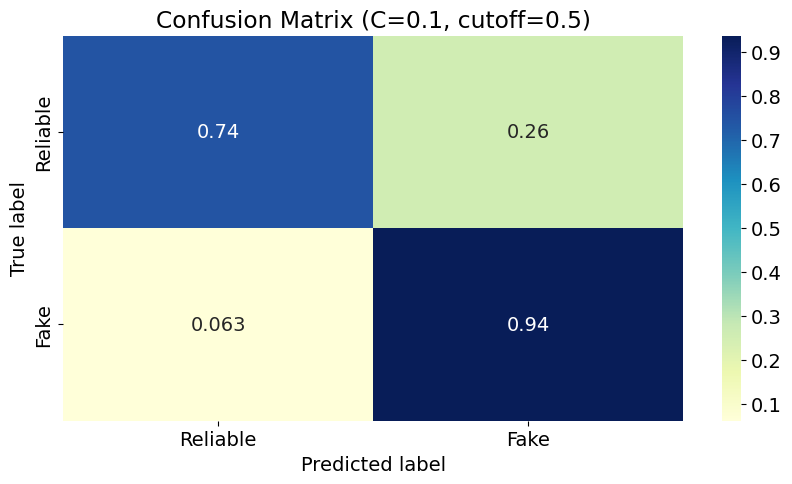

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

Cs = [0.1]
best_accuracy = 0
best_c = 0
best_y_pred = None

for c in Cs:
    simple_log_model = LogisticRegression(max_iter=100000, C=c, class_weight='balanced')
    simple_log_model.fit(X_train_vec, y_train_bin)
    y_pred = simple_log_model.predict(X_val_vec)
    accuracy = accuracy_score(y_val_bin, y_pred)
    print(f"Accuracy for C={c}: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_c = c
        best_y_pred = y_pred

print("Best C:", best_c)

# generate class probabilities and select cutoff
probas = simple_log_model.predict_proba(X_val_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f'Confusion Matrix (C={best_c}, cutoff={cutoff})')
plt.show()


<AxesSubplot: >

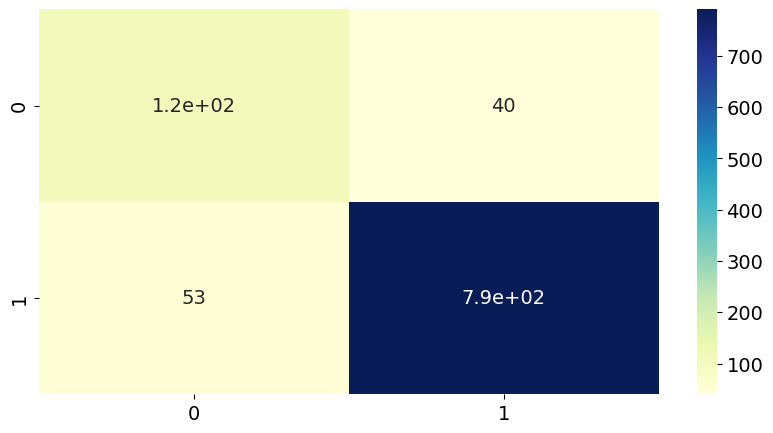

In [ ]:
# calculate and plot confusion matrix with absolute values
conf_mat1 = confusion_matrix(y_val_bin, best_y_pred)
sns.heatmap(conf_mat1, annot=True, cmap="YlGnBu")

#### Simlpe logistic model, with author and domain

In [ ]:

for index, row in df.iterrows():
    #print("df.at[index,'authors']", df.at[index,'authors'])
    if df.at[index,'authors'] != "nan":
        split_str = str(df.at[index,'authors']).split(", ")
        for word in split_str:
            author_str = "authors: " + word.lower()
            df.at[index,'content'].append(author_str)
    if  df.at[index,'domain'] != "nan":
        domain_str = "domain: " + str(df.at[index,'domain'])
        df.at[index,'content'].append(domain_str.lower())
    

#print(df['content'][1])

X_meta, y_meta = df.content, df['type']


X_train_meta, X_temp_meta, y_train_meta, y_temp_meta = train_test_split(X_meta, y_meta, test_size = 0.2, random_state = 0)
X_test_meta, X_val_meta, y_test_meta, y_val_meta = train_test_split(X_temp_meta, y_temp_meta, test_size = 0.5, random_state = 0)


X_train_vec_meta = X_vectoriser(X_train_meta)
X_val_vec_meta = X_vectoriser(X_val_meta)
X_test_vec_meta = X_vectoriser(X_test_meta)

y_train_bin_meta = make_bin(y_train_meta)
y_val_bin_meta = make_bin(y_val_meta)
y_test_bin_meta = make_bin(y_test_meta)





TypeError: 'str' object is not callable

In [ ]:
simple_log_model_meta = LogisticRegression(max_iter=100000)
simple_log_model_meta.fit(X_train_vec_meta, y_train_bin_meta)
y_pred_meta = simple_log_model_meta.predict(X_val_vec_meta)

acc_simple_log_meta = accuracy_score(y_val_bin_meta, y_pred_meta)
print(accuracy_score(y_val_bin_meta, y_pred_meta))

0.972


In [ ]:
#Comparison of acc bewteen simple log models

acc_diff_logs = abs(acc_simple_log_meta - acc_simple_log)
print(acc_diff_logs)

0.020000000000000018


In [ ]:
# create a RandomUnderSampler instance
rus_meta = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled_meta, y_train_resampled_meta = rus_meta.fit_resample(X_train_vec_meta.toarray(), y_train_bin_meta)

# train the model on the resampled data
simple_nb_model_meta = GaussianNB()
simple_nb_model_meta.fit(X_train_resampled_meta, y_train_resampled_meta)

# make predictions on the validation data
y_pred2_meta = simple_nb_model_meta.predict(X_val_vec_meta.toarray())

# evaluate the accuracy of the model's predictions
acc_gaus_meta = accuracy_score(y_val_bin_meta, y_pred2_meta)
print(accuracy_score(y_val_bin_meta, y_pred2_meta))

0.758


In [ ]:
#Comparison of acc between simple gauss models
#Frst run randomstate=42: 0.038000000000000034
#Second run, randomstate=0: 0.04

acc_diff_gauss = abs(acc_gaus - acc_gaus_meta)
print(acc_diff_gauss)

0.040000000000000036
